# ANBW_v3
- To do
    - Improve model performance
    - Reusable Pipeline Configuration
    - Apply appropriate garbage collecting

## Setup

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

In [2]:
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print("CUDA avilable:",
     True if tf.config.list_physical_devices("GPU") else False)

CUDA avilable: True


In [4]:
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load data

In [5]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
# submission = pd.read_csv("./dataset/submission.csv")

In [6]:
img_save_path = "./img/v3/"

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))
    print("Directory Created: %s" % img_save_path)
else:
    print("Directory already exists: %s" % img_save_path)

Directory already exists: ./img/v3/


## EDA

### Plot saving function

In [7]:
def save_plot(img_path: str) -> None:
    if not(os.path.isfile(img_path)):
        plt.savefig(img_path, facecolor="#eeeeee", bbox_inches="tight")
        print("successfully image saved: %s" % img_path)
    else:
        print("Directory already exists: %s" % img_path)

### Train data

In [8]:
train.set_index("id").head()

,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


In [9]:
train_digit_cnt = train["digit"].value_counts(normalize=False, sort=False).values
train_digit_label = sorted(train["digit"].unique())

Directory already exists: ./img/v3/train_digit_distribution.png


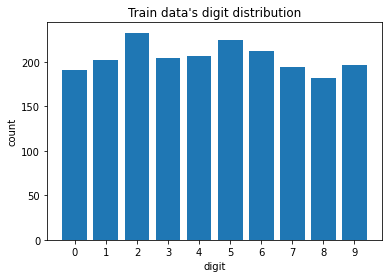

In [10]:
plt.bar(train_digit_label, train_digit_cnt)
plt.title("Train data's digit distribution")
plt.xticks(train_digit_label)
plt.xlabel("digit")
plt.ylabel("count")

img_path = img_save_path + "train_digit_distribution.png"
save_plot(img_path)

In [11]:
train.shape

(2048, 787)

### Test data

In [12]:
test.set_index("id").head()

,letter,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,...,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,...,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,...,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,...,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,...,4,3,1,4,0,2,1,2,3,4


In [13]:
test.shape

(20480, 786)

### Data visualization

Directory already exists: ./img/v3/train_visualize.png


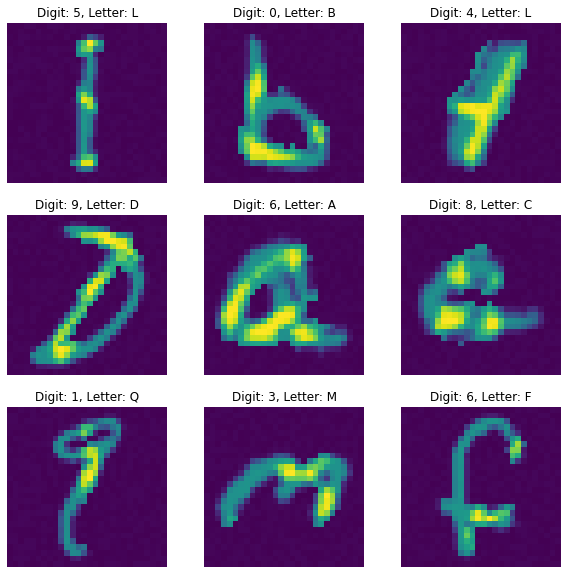

In [14]:
plt.figure(figsize=(10, 10))
for idx in range(9):
    ax = plt.subplot(3, 3, idx+1)
    img = train.loc[idx, "0": ].values.reshape(28, 28).astype(int)
    plt.imshow(img)
    plt.title("Digit: %s, Letter: %s" % (train.loc[idx, "digit"], train.loc[idx, "letter"]))
    plt.axis("off")

img_path = img_save_path + "train_visualize.png"
save_plot(img_path)

In [15]:
del ax, idx, img, img_path, img_save_path, train, test, train_digit_cnt, train_digit_label
gc.collect()

26494

## Data preprocessing & Set Hyper-parameter

In [16]:
BATCH = 4
EPOCHS = 100
BUFFER_SIZE = 2048

In [17]:
def train_validation_generator(path: str, fraction: float) -> (tf.float32, tf.float32):
    """
    Train/Validation Image data preproccesing and generating
    1. Read CSV file with Pandas and split data to train/data
    2. Slice the feature data(pixels) and label(digit)
    3. Convert Color from grayscale to RGB
    4. Resize image from (28, 28) to (300, 300)
    5. Convert labels to one hot encoding array and return with preprocessed image
    """    
    raw_data = pd.read_csv(path, engine="python")
    raw_data = raw_data.sample(frac=fraction, random_state=SEED)
    
    features = raw_data.drop(["id", "digit", "letter"], axis=1).values
    features = features.reshape(-1, 28, 28, 1)
    features = np.where((features<=20)&(features!=0), 0., features)
    features = features / 255
    features = features.astype("float32")
    
    labels = raw_data["digit"]
    
    for feat, label in zip(features, labels):
        cvt_feat = cv2.cvtColor(feat, cv2.COLOR_GRAY2RGB)
        resized_feat = cv2.resize(cvt_feat, (300, 300), interpolation=cv2.INTER_CUBIC)
        label = tf.keras.utils.to_categorical(label, 10)
        
        yield(resized_feat, label)

In [18]:
def test_generator(path: str) -> (tf.float32):
    """
    Test Image data preproccesing and generating
    1. Read CSV file with Pandas
    2. Slice the feature data(pixels)
    3. Convert Color from grayscale to RGB
    4. Resize image from (28, 28) to (300, 300)
    5. Return preprocessed image
    """
    raw_data = pd.read_csv(path, engine="python")
    
    features = raw_data.drop(["id", "digit", "letter"], axis=1).values
    features = features.reshape(-1, 28, 28, 1)
    features = np.where((features<=20)&(features!=0), 0., features)
    features = features / 255
    features = features.astype("float32")
    
    for feat in features:
        cvt_feat = cv2.cvtColor(feat, cv2.COLOR_GRAY2RGB)
        resized_feat = cv2.resize(cvt_feat, (300, 300), interpolation=cv2.INTER_CUBIC)
        
        yield(resized_feat)

In [19]:
# Have to give args to generator with using lambda
# Train: 0.8
# Validation: 0.2

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_validation_generator(path="./dataset/train.csv", fraction=0.8),
    (tf.float32, tf.float32),
    ([300, 300, 3], [10])
)
train_dataset = train_dataset.batch(BATCH).shuffle(buffer_size=BUFFER_SIZE, seed=SEED)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: train_validation_generator(path="./dataset/train.csv", fraction=0.2),
    (tf.float32, tf.float32),
    ([300, 300, 3], [10])
)
validation_dataset = validation_dataset.batch(BATCH).shuffle(buffer_size=BUFFER_SIZE, seed=SEED)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator(path="./dataset/test.csv"),
    (tf.float32),
    ([300, 300, 3])
)
test_dataset = test_dataset.batch(BATCH).shuffle(buffer_size=BUFFER_SIZE, seed=SEED)

## Initialing model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [21]:
model_save_dir = "./model/v3/"

if not(os.path.isdir(model_save_dir)):
    os.makedirs(os.path.join(model_save_dir))
    print("Directory Created: %s" % model_save_dir)
else:
    print("Directory already exists: %s" % model_save_dir)

Directory already exists: ./model/v3/


In [22]:
model_save_path = model_save_dir + "/ckp-epoch-{epoch:02d}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    monitor="val_accuracy",
    save_best_only=False,
    save_freq=5,
    verbose=1
)

early_stopping = EarlyStopping(monitor="val_loss", verbose=1, patience=10),

reduce_LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1,
                      min_lr=0.00001, verbose=1, mode="min")

In [23]:
CALLBACKS = [
    model_checkpoint_callback,
    early_stopping,
    reduce_LR
]

In [24]:
effnet = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights=None,
    input_shape=(300, 300, 3),
    classes=10,
    classifier_activation="softmax",
)

In [25]:
model = tf.keras.Sequential()
model.add(effnet)

model.compile(loss="categorical_crossentropy",
             optimizer="RMSprop",
             metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10)                10798905  
Total params: 10,798,905
Trainable params: 10,711,602
Non-trainable params: 87,303
_________________________________________________________________


In [27]:
history = model.fit(train_dataset,
                    batch_size=BATCH,
                    epochs=EPOCHS,
                    callbacks=CALLBACKS,
                    validation_data=validation_dataset)

Epoch 1/100
      2/Unknown - 0s 184ms/step - loss: 5.3030 - accuracy: 0.1250 WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1150s vs `on_train_batch_end` time: 0.2530s). Check your callbacks.
      4/Unknown - 1s 276ms/step - loss: 7.0593 - accuracy: 0.1250
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
      9/Unknown - 4s 395ms/step - loss: 11.1792 - accuracy: 0.1667
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
     14/Unknown - 6s 431ms/step - loss: 10.4377 - accuracy: 0.1250
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
     19/Unknown - 9s 448ms/step - loss: 9.2456 - accuracy: 0.1447
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
     24/Unknown - 11s 457ms/step - loss: 8.1203 - accuracy: 0.1562
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
     29/Unknown - 13s 463ms/step - loss: 7.6321 - accuracy: 0.1379
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
     34/Unk

    324/Unknown - 162s 501ms/step - loss: 3.1578 - accuracy: 0.1298
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    329/Unknown - 165s 501ms/step - loss: 3.1449 - accuracy: 0.1324
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    334/Unknown - 167s 501ms/step - loss: 3.1386 - accuracy: 0.1304
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    339/Unknown - 170s 501ms/step - loss: 3.1287 - accuracy: 0.1285
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    344/Unknown - 172s 501ms/step - loss: 3.1168 - accuracy: 0.1288
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    349/Unknown - 175s 501ms/step - loss: 3.1075 - accuracy: 0.1284
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    354/Unknown - 177s 500ms/step - loss: 3.0920 - accuracy: 0.1294
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    359/Unknown - 180s 500ms/step - loss: 3.0825 - accuracy: 0.1290
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
    364/

209/410 [==============>...............] - ETA: 1:39 - loss: 2.2929 - accuracy: 0.1787
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
214/410 [==============>...............] - ETA: 1:37 - loss: 2.2935 - accuracy: 0.1827
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
219/410 [===============>..............] - ETA: 1:34 - loss: 2.2916 - accuracy: 0.1842
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
224/410 [===============>..............] - ETA: 1:32 - loss: 2.2870 - accuracy: 0.1868
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
229/410 [===============>..............] - ETA: 1:29 - loss: 2.2912 - accuracy: 0.1871
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
234/410 [================>.............] - ETA: 1:27 - loss: 2.2878 - accuracy: 0.1895
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
239/410 [================>.............] - ETA: 1:24 - loss: 2.2920 - accuracy: 0.1897
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5

 79/410 [====>.........................] - ETA: 2:40 - loss: 1.9994 - accuracy: 0.3006
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 84/410 [=====>........................] - ETA: 2:38 - loss: 2.0166 - accuracy: 0.2946
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 89/410 [=====>........................] - ETA: 2:36 - loss: 2.0150 - accuracy: 0.2921
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 94/410 [=====>........................] - ETA: 2:34 - loss: 1.9951 - accuracy: 0.3005
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 99/410 [======>.......................] - ETA: 2:31 - loss: 1.9933 - accuracy: 0.3056
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
104/410 [======>.......................] - ETA: 2:29 - loss: 1.9748 - accuracy: 0.3077
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
109/410 [======>.......................] - ETA: 2:27 - loss: 1.9801 - accuracy: 0.3142
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5

364/410 [=========================>....] - ETA: 22s - loss: 1.8661 - accuracy: 0.3556
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
369/410 [==========================>...] - ETA: 20s - loss: 1.8657 - accuracy: 0.3535
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
374/410 [==========================>...] - ETA: 17s - loss: 1.8643 - accuracy: 0.3561
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
379/410 [==========================>...] - ETA: 15s - loss: 1.8627 - accuracy: 0.3573
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
384/410 [===========================>..] - ETA: 12s - loss: 1.8619 - accuracy: 0.3579
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
389/410 [===========================>..] - ETA: 10s - loss: 1.8628 - accuracy: 0.3584
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
394/410 [===========================>..] - ETA: 7s - loss: 1.8597 - accuracy: 0.3609
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
399/410

234/410 [================>.............] - ETA: 1:24 - loss: 1.5940 - accuracy: 0.4509
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
239/410 [================>.............] - ETA: 1:21 - loss: 1.5884 - accuracy: 0.4539
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
244/410 [================>.............] - ETA: 1:19 - loss: 1.5899 - accuracy: 0.4528
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
249/410 [=================>............] - ETA: 1:16 - loss: 1.5806 - accuracy: 0.4567
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
254/410 [=================>............] - ETA: 1:14 - loss: 1.5754 - accuracy: 0.4576
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
259/410 [=================>............] - ETA: 1:12 - loss: 1.5720 - accuracy: 0.4565
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
264/410 [==================>...........] - ETA: 1:09 - loss: 1.5663 - accuracy: 0.4583
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5

104/410 [======>.......................] - ETA: 2:26 - loss: 1.3261 - accuracy: 0.5505
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
109/410 [======>.......................] - ETA: 2:24 - loss: 1.3188 - accuracy: 0.5436
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
114/410 [=======>......................] - ETA: 2:21 - loss: 1.3084 - accuracy: 0.5482
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
119/410 [=======>......................] - ETA: 2:19 - loss: 1.3241 - accuracy: 0.5441
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
124/410 [========>.....................] - ETA: 2:17 - loss: 1.3121 - accuracy: 0.5464
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
129/410 [========>.....................] - ETA: 2:15 - loss: 1.3127 - accuracy: 0.5504
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
134/410 [========>.....................] - ETA: 2:13 - loss: 1.3131 - accuracy: 0.5522
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5

389/410 [===========================>..] - ETA: 10s - loss: 1.2677 - accuracy: 0.5849
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
394/410 [===========================>..] - ETA: 7s - loss: 1.2738 - accuracy: 0.5851
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
399/410 [============================>.] - ETA: 5s - loss: 1.2705 - accuracy: 0.5853
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
404/410 [============================>.] - ETA: 2s - loss: 1.2722 - accuracy: 0.5843
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
409/410 [============================>.] - ETA: 0s - loss: 1.2757 - accuracy: 0.5826
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
410/410 [==============================] - 209s 509ms/step - loss: 1.2762 - accuracy: 0.5824 - val_loss: 0.9195 - val_accuracy: 0.6805
Epoch 6/100
  4/410 [..............................] - ETA: 1:51 - loss: 0.8428 - accuracy: 0.7500
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
  9/

259/410 [=================>............] - ETA: 1:12 - loss: 1.0585 - accuracy: 0.6644
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
264/410 [==================>...........] - ETA: 1:09 - loss: 1.0549 - accuracy: 0.6660
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
269/410 [==================>...........] - ETA: 1:07 - loss: 1.0641 - accuracy: 0.6657
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
274/410 [===================>..........] - ETA: 1:05 - loss: 1.0691 - accuracy: 0.6636
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
279/410 [===================>..........] - ETA: 1:02 - loss: 1.0575 - accuracy: 0.6670
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
284/410 [===================>..........] - ETA: 1:00 - loss: 1.0591 - accuracy: 0.6684
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
289/410 [====================>.........] - ETA: 57s - loss: 1.0538 - accuracy: 0.6698
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5


129/410 [========>.....................] - ETA: 2:13 - loss: 0.9471 - accuracy: 0.6996
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
134/410 [========>.....................] - ETA: 2:11 - loss: 0.9278 - accuracy: 0.7090
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
139/410 [=========>....................] - ETA: 2:09 - loss: 0.9432 - accuracy: 0.7086
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
144/410 [=========>....................] - ETA: 2:06 - loss: 0.9358 - accuracy: 0.7101
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
149/410 [=========>....................] - ETA: 2:04 - loss: 0.9540 - accuracy: 0.7030
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
154/410 [==========>...................] - ETA: 2:02 - loss: 0.9502 - accuracy: 0.7078
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
159/410 [==========>...................] - ETA: 2:00 - loss: 0.9614 - accuracy: 0.7044
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5

410/410 [==============================] - 206s 503ms/step - loss: 0.9191 - accuracy: 0.7167 - val_loss: 0.5878 - val_accuracy: 0.8317
Epoch 8/100
  4/410 [..............................] - ETA: 1:48 - loss: 1.2223 - accuracy: 0.6875
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
  9/410 [..............................] - ETA: 2:30 - loss: 0.7164 - accuracy: 0.7778
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
 14/410 [>.............................] - ETA: 2:42 - loss: 0.5577 - accuracy: 0.8393
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
 19/410 [>.............................] - ETA: 2:47 - loss: 0.7358 - accuracy: 0.7500
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
 24/410 [>.............................] - ETA: 2:49 - loss: 0.7944 - accuracy: 0.7292
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
 29/410 [=>............................] - ETA: 2:52 - loss: 0.7422 - accuracy: 0.7414
Epoch 00008: saving model to ./model/v3\ckp-epoch-0

284/410 [===================>..........] - ETA: 1:00 - loss: 0.8211 - accuracy: 0.7522
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
289/410 [====================>.........] - ETA: 58s - loss: 0.8234 - accuracy: 0.7522
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
294/410 [====================>.........] - ETA: 55s - loss: 0.8281 - accuracy: 0.7504
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
299/410 [====================>.........] - ETA: 53s - loss: 0.8235 - accuracy: 0.7521
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
304/410 [=====================>........] - ETA: 50s - loss: 0.8213 - accuracy: 0.7521
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
309/410 [=====================>........] - ETA: 48s - loss: 0.8196 - accuracy: 0.7504
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
314/410 [=====================>........] - ETA: 46s - loss: 0.8130 - accuracy: 0.7520
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
319/4

149/410 [=========>....................] - ETA: 2:04 - loss: 0.5073 - accuracy: 0.8389
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
154/410 [==========>...................] - ETA: 2:01 - loss: 0.5192 - accuracy: 0.8328
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
159/410 [==========>...................] - ETA: 1:59 - loss: 0.5160 - accuracy: 0.8333
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
164/410 [===========>..................] - ETA: 1:57 - loss: 0.5219 - accuracy: 0.8293
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
169/410 [===========>..................] - ETA: 1:54 - loss: 0.5202 - accuracy: 0.8299
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
174/410 [===========>..................] - ETA: 1:52 - loss: 0.5277 - accuracy: 0.8276
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
179/410 [============>.................] - ETA: 1:49 - loss: 0.5234 - accuracy: 0.8291
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5

 19/410 [>.............................] - ETA: 2:50 - loss: 0.2777 - accuracy: 0.9211
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
 24/410 [>.............................] - ETA: 2:51 - loss: 0.3271 - accuracy: 0.9167
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
 29/410 [=>............................] - ETA: 2:51 - loss: 0.3214 - accuracy: 0.9052
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
 34/410 [=>............................] - ETA: 2:50 - loss: 0.2951 - accuracy: 0.9118
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
 39/410 [=>............................] - ETA: 2:51 - loss: 0.3320 - accuracy: 0.9038
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
 44/410 [==>...........................] - ETA: 2:49 - loss: 0.3292 - accuracy: 0.9034
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
 49/410 [==>...........................] - ETA: 2:47 - loss: 0.3518 - accuracy: 0.8878
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5

304/410 [=====================>........] - ETA: 50s - loss: 0.3375 - accuracy: 0.8954
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
309/410 [=====================>........] - ETA: 48s - loss: 0.3366 - accuracy: 0.8955
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
314/410 [=====================>........] - ETA: 46s - loss: 0.3338 - accuracy: 0.8955
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
319/410 [======================>.......] - ETA: 43s - loss: 0.3301 - accuracy: 0.8964
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
324/410 [======================>.......] - ETA: 41s - loss: 0.3288 - accuracy: 0.8964
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
329/410 [=======================>......] - ETA: 38s - loss: 0.3267 - accuracy: 0.8973
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
334/410 [=======================>......] - ETA: 36s - loss: 0.3261 - accuracy: 0.8966
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
339/41

174/410 [===========>..................] - ETA: 1:53 - loss: 0.2745 - accuracy: 0.9092
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
179/410 [============>.................] - ETA: 1:50 - loss: 0.2711 - accuracy: 0.9090
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
184/410 [============>.................] - ETA: 1:48 - loss: 0.2663 - accuracy: 0.9101
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
189/410 [============>.................] - ETA: 1:46 - loss: 0.2680 - accuracy: 0.9085
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
194/410 [=============>................] - ETA: 1:43 - loss: 0.2703 - accuracy: 0.9070
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
199/410 [=============>................] - ETA: 1:41 - loss: 0.2908 - accuracy: 0.9005
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
204/410 [=============>................] - ETA: 1:38 - loss: 0.2971 - accuracy: 0.9005
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5

 44/410 [==>...........................] - ETA: 2:48 - loss: 0.1781 - accuracy: 0.9545
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 49/410 [==>...........................] - ETA: 2:46 - loss: 0.1671 - accuracy: 0.9592
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 54/410 [==>...........................] - ETA: 2:45 - loss: 0.1844 - accuracy: 0.9491
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 59/410 [===>..........................] - ETA: 2:43 - loss: 0.1886 - accuracy: 0.9449
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 64/410 [===>..........................] - ETA: 2:43 - loss: 0.2071 - accuracy: 0.9297
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 69/410 [====>.........................] - ETA: 2:41 - loss: 0.2138 - accuracy: 0.9275
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 74/410 [====>.........................] - ETA: 2:39 - loss: 0.2246 - accuracy: 0.9223
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5

329/410 [=======================>......] - ETA: 39s - loss: 0.2222 - accuracy: 0.9285
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
334/410 [=======================>......] - ETA: 36s - loss: 0.2233 - accuracy: 0.9265
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
339/410 [=======================>......] - ETA: 34s - loss: 0.2326 - accuracy: 0.9239
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
344/410 [========================>.....] - ETA: 31s - loss: 0.2343 - accuracy: 0.9229
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
349/410 [========================>.....] - ETA: 29s - loss: 0.2363 - accuracy: 0.9218
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
354/410 [========================>.....] - ETA: 26s - loss: 0.2382 - accuracy: 0.9215
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
359/410 [=========================>....] - ETA: 24s - loss: 0.2420 - accuracy: 0.9212
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
364/41

194/410 [=============>................] - ETA: 1:43 - loss: 0.1098 - accuracy: 0.9613
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
199/410 [=============>................] - ETA: 1:41 - loss: 0.1072 - accuracy: 0.9623
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
204/410 [=============>................] - ETA: 1:38 - loss: 0.1061 - accuracy: 0.9620
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
209/410 [==============>...............] - ETA: 1:36 - loss: 0.1104 - accuracy: 0.9605
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
214/410 [==============>...............] - ETA: 1:34 - loss: 0.1090 - accuracy: 0.9614
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
219/410 [===============>..............] - ETA: 1:31 - loss: 0.1120 - accuracy: 0.9612
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
224/410 [===============>..............] - ETA: 1:29 - loss: 0.1141 - accuracy: 0.9587
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5

 64/410 [===>..........................] - ETA: 2:42 - loss: 0.0706 - accuracy: 0.9805
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 69/410 [====>.........................] - ETA: 2:40 - loss: 0.0763 - accuracy: 0.9783
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 74/410 [====>.........................] - ETA: 2:38 - loss: 0.0721 - accuracy: 0.9797
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 79/410 [====>.........................] - ETA: 2:36 - loss: 0.0964 - accuracy: 0.9747
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 84/410 [=====>........................] - ETA: 2:34 - loss: 0.0912 - accuracy: 0.9762
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 89/410 [=====>........................] - ETA: 2:31 - loss: 0.0896 - accuracy: 0.9747
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 94/410 [=====>........................] - ETA: 2:29 - loss: 0.0854 - accuracy: 0.9761
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5

349/410 [========================>.....] - ETA: 29s - loss: 0.0892 - accuracy: 0.9763
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
354/410 [========================>.....] - ETA: 27s - loss: 0.0882 - accuracy: 0.9767
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
359/410 [=========================>....] - ETA: 24s - loss: 0.0897 - accuracy: 0.9763
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
364/410 [=========================>....] - ETA: 22s - loss: 0.0886 - accuracy: 0.9766
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
369/410 [==========================>...] - ETA: 20s - loss: 0.0877 - accuracy: 0.9769
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
374/410 [==========================>...] - ETA: 17s - loss: 0.0867 - accuracy: 0.9772
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
379/410 [==========================>...] - ETA: 15s - loss: 0.0860 - accuracy: 0.9775
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
384/41

214/410 [==============>...............] - ETA: 1:34 - loss: 0.0547 - accuracy: 0.9871
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
219/410 [===============>..............] - ETA: 1:32 - loss: 0.0546 - accuracy: 0.9874
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
224/410 [===============>..............] - ETA: 1:29 - loss: 0.0534 - accuracy: 0.9877
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
229/410 [===============>..............] - ETA: 1:27 - loss: 0.0557 - accuracy: 0.9869
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
234/410 [================>.............] - ETA: 1:24 - loss: 0.0547 - accuracy: 0.9872
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
239/410 [================>.............] - ETA: 1:22 - loss: 0.0539 - accuracy: 0.9874
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
244/410 [================>.............] - ETA: 1:20 - loss: 0.0542 - accuracy: 0.9867
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5

 84/410 [=====>........................] - ETA: 2:34 - loss: 0.0130 - accuracy: 1.0000
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 89/410 [=====>........................] - ETA: 2:32 - loss: 0.0123 - accuracy: 1.0000
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 94/410 [=====>........................] - ETA: 2:29 - loss: 0.0117 - accuracy: 1.0000
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 99/410 [======>.......................] - ETA: 2:27 - loss: 0.0115 - accuracy: 1.0000
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
104/410 [======>.......................] - ETA: 2:25 - loss: 0.0112 - accuracy: 1.0000
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
109/410 [======>.......................] - ETA: 2:23 - loss: 0.0137 - accuracy: 0.9977
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
114/410 [=======>......................] - ETA: 2:20 - loss: 0.0134 - accuracy: 0.9978
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5

369/410 [==========================>...] - ETA: 19s - loss: 0.0285 - accuracy: 0.9925
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
374/410 [==========================>...] - ETA: 17s - loss: 0.0282 - accuracy: 0.9926
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
379/410 [==========================>...] - ETA: 14s - loss: 0.0293 - accuracy: 0.9921
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
384/410 [===========================>..] - ETA: 12s - loss: 0.0290 - accuracy: 0.9922
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
389/410 [===========================>..] - ETA: 10s - loss: 0.0287 - accuracy: 0.9923
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
394/410 [===========================>..] - ETA: 7s - loss: 0.0283 - accuracy: 0.9924
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
399/410 [============================>.] - ETA: 5s - loss: 0.0281 - accuracy: 0.9925
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
404/410 

239/410 [================>.............] - ETA: 1:21 - loss: 0.0208 - accuracy: 0.9937
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
244/410 [================>.............] - ETA: 1:19 - loss: 0.0207 - accuracy: 0.9938
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
249/410 [=================>............] - ETA: 1:16 - loss: 0.0203 - accuracy: 0.9940
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
254/410 [=================>............] - ETA: 1:14 - loss: 0.0222 - accuracy: 0.9931
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
259/410 [=================>............] - ETA: 1:11 - loss: 0.0218 - accuracy: 0.9932
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
264/410 [==================>...........] - ETA: 1:09 - loss: 0.0217 - accuracy: 0.9934
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
269/410 [==================>...........] - ETA: 1:07 - loss: 0.0213 - accuracy: 0.9935
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5

109/410 [======>.......................] - ETA: 2:21 - loss: 0.0152 - accuracy: 0.9931
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
114/410 [=======>......................] - ETA: 2:19 - loss: 0.0146 - accuracy: 0.9934
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
119/410 [=======>......................] - ETA: 2:16 - loss: 0.0164 - accuracy: 0.9937
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
124/410 [========>.....................] - ETA: 2:15 - loss: 0.0158 - accuracy: 0.9940
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
129/410 [========>.....................] - ETA: 2:12 - loss: 0.0156 - accuracy: 0.9942
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
134/410 [========>.....................] - ETA: 2:10 - loss: 0.0154 - accuracy: 0.9944
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
139/410 [=========>....................] - ETA: 2:08 - loss: 0.0149 - accuracy: 0.9946
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5

394/410 [===========================>..] - ETA: 7s - loss: 0.0262 - accuracy: 0.9924
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
399/410 [============================>.] - ETA: 5s - loss: 0.0259 - accuracy: 0.9925
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
404/410 [============================>.] - ETA: 2s - loss: 0.0256 - accuracy: 0.9926
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
409/410 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9927
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
410/410 [==============================] - 205s 501ms/step - loss: 0.0253 - accuracy: 0.9927 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 19/100
  4/410 [..............................] - ETA: 1:48 - loss: 4.0308e-04 - accuracy: 1.0000
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
  9/410 [..............................] - ETA: 2:30 - loss: 0.0066 - accuracy: 1.0000
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h

264/410 [==================>...........] - ETA: 1:09 - loss: 0.0326 - accuracy: 0.9905
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
269/410 [==================>...........] - ETA: 1:07 - loss: 0.0320 - accuracy: 0.9907
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
274/410 [===================>..........] - ETA: 1:05 - loss: 0.0314 - accuracy: 0.9909
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
279/410 [===================>..........] - ETA: 1:02 - loss: 0.0309 - accuracy: 0.9910
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
284/410 [===================>..........] - ETA: 1:00 - loss: 0.0304 - accuracy: 0.9912
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
289/410 [====================>.........] - ETA: 57s - loss: 0.0298 - accuracy: 0.9913
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
294/410 [====================>.........] - ETA: 55s - loss: 0.0293 - accuracy: 0.9915
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
2

129/410 [========>.....................] - ETA: 2:13 - loss: 0.0047 - accuracy: 0.9981
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
134/410 [========>.....................] - ETA: 2:11 - loss: 0.0046 - accuracy: 0.9981
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
139/410 [=========>....................] - ETA: 2:08 - loss: 0.0112 - accuracy: 0.9964
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
144/410 [=========>....................] - ETA: 2:06 - loss: 0.0109 - accuracy: 0.9965
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
149/410 [=========>....................] - ETA: 2:04 - loss: 0.0144 - accuracy: 0.9949
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
154/410 [==========>...................] - ETA: 2:01 - loss: 0.0167 - accuracy: 0.9935
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
159/410 [==========>...................] - ETA: 1:59 - loss: 0.0167 - accuracy: 0.9937
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5

410/410 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9945
Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
410/410 [==============================] - 206s 502ms/step - loss: 0.0197 - accuracy: 0.9945 - val_loss: 0.0212 - val_accuracy: 0.9927
Epoch 21/100
  4/410 [..............................] - ETA: 1:48 - loss: 2.9515e-04 - accuracy: 1.0000
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
  9/410 [..............................] - ETA: 2:30 - loss: 0.0426 - accuracy: 0.9722
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
 14/410 [>.............................] - ETA: 2:43 - loss: 0.0276 - accuracy: 0.9821
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
 19/410 [>.............................] - ETA: 2:48 - loss: 0.0205 - accuracy: 0.9868
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
 24/410 [>.............................] - ETA: 2:51 - loss: 0.0163 - accuracy: 0.9896
Epoch 00021: saving mode

279/410 [===================>..........] - ETA: 1:02 - loss: 0.0066 - accuracy: 0.9973
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
284/410 [===================>..........] - ETA: 1:00 - loss: 0.0065 - accuracy: 0.9974
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
289/410 [====================>.........] - ETA: 58s - loss: 0.0064 - accuracy: 0.9974
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
294/410 [====================>.........] - ETA: 55s - loss: 0.0068 - accuracy: 0.9974
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
299/410 [====================>.........] - ETA: 53s - loss: 0.0077 - accuracy: 0.9975
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
304/410 [=====================>........] - ETA: 50s - loss: 0.0076 - accuracy: 0.9975
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
309/410 [=====================>........] - ETA: 48s - loss: 0.0075 - accuracy: 0.9976
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
314/

144/410 [=========>....................] - ETA: 2:06 - loss: 0.0084 - accuracy: 0.9983
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5
149/410 [=========>....................] - ETA: 2:04 - loss: 0.0134 - accuracy: 0.9966
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5
154/410 [==========>...................] - ETA: 2:01 - loss: 0.0130 - accuracy: 0.9968
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5
159/410 [==========>...................] - ETA: 1:59 - loss: 0.0126 - accuracy: 0.9969
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5
164/410 [===========>..................] - ETA: 1:57 - loss: 0.0152 - accuracy: 0.9954
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5
169/410 [===========>..................] - ETA: 1:54 - loss: 0.0148 - accuracy: 0.9956
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5
174/410 [===========>..................] - ETA: 1:52 - loss: 0.0154 - accuracy: 0.9943
Epoch 00022: saving model to ./model/v3\ckp-epoch-22.h5

  9/410 [..............................] - ETA: 2:30 - loss: 0.0019 - accuracy: 1.0000
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
 14/410 [>.............................] - ETA: 2:44 - loss: 0.0013 - accuracy: 1.0000
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
 19/410 [>.............................] - ETA: 2:49 - loss: 0.0139 - accuracy: 0.9868
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
 24/410 [>.............................] - ETA: 2:50 - loss: 0.0112 - accuracy: 0.9896
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
 29/410 [=>............................] - ETA: 2:50 - loss: 0.0094 - accuracy: 0.9914
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
 34/410 [=>............................] - ETA: 2:50 - loss: 0.0081 - accuracy: 0.9926
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
 39/410 [=>............................] - ETA: 2:49 - loss: 0.0080 - accuracy: 0.9936
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5

294/410 [====================>.........] - ETA: 55s - loss: 0.0070 - accuracy: 0.9974
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
299/410 [====================>.........] - ETA: 52s - loss: 0.0069 - accuracy: 0.9975
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
304/410 [=====================>........] - ETA: 50s - loss: 0.0069 - accuracy: 0.9975
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
309/410 [=====================>........] - ETA: 48s - loss: 0.0068 - accuracy: 0.9976
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
314/410 [=====================>........] - ETA: 45s - loss: 0.0067 - accuracy: 0.9976
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
319/410 [======================>.......] - ETA: 43s - loss: 0.0066 - accuracy: 0.9976
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
324/410 [======================>.......] - ETA: 41s - loss: 0.0068 - accuracy: 0.9977
Epoch 00023: saving model to ./model/v3\ckp-epoch-23.h5
329/41

164/410 [===========>..................] - ETA: 1:56 - loss: 0.0109 - accuracy: 0.9954
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5
169/410 [===========>..................] - ETA: 1:54 - loss: 0.0106 - accuracy: 0.9955
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5
174/410 [===========>..................] - ETA: 1:52 - loss: 0.0103 - accuracy: 0.9957
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5
179/410 [============>.................] - ETA: 1:50 - loss: 0.0100 - accuracy: 0.9958
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5
184/410 [============>.................] - ETA: 1:47 - loss: 0.0098 - accuracy: 0.9959
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5
189/410 [============>.................] - ETA: 1:45 - loss: 0.0095 - accuracy: 0.9960
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5
194/410 [=============>................] - ETA: 1:42 - loss: 0.0095 - accuracy: 0.9961
Epoch 00024: saving model to ./model/v3\ckp-epoch-24.h5

 34/410 [=>............................] - ETA: 2:54 - loss: 3.2972e-04 - accuracy: 1.0000
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
 39/410 [=>............................] - ETA: 2:52 - loss: 4.4602e-04 - accuracy: 1.0000
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
 44/410 [==>...........................] - ETA: 2:50 - loss: 5.4626e-04 - accuracy: 1.0000
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
 49/410 [==>...........................] - ETA: 2:49 - loss: 5.1731e-04 - accuracy: 1.0000
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
 54/410 [==>...........................] - ETA: 2:47 - loss: 4.9725e-04 - accuracy: 1.0000
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
 59/410 [===>..........................] - ETA: 2:44 - loss: 6.1384e-04 - accuracy: 1.0000
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
 64/410 [===>..........................] - ETA: 2:42 - loss: 0.0011 - accuracy: 1.0000  
Epoch 00025: saving model to 

319/410 [======================>.......] - ETA: 43s - loss: 0.0160 - accuracy: 0.9969
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
324/410 [======================>.......] - ETA: 41s - loss: 0.0160 - accuracy: 0.9969
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
329/410 [=======================>......] - ETA: 38s - loss: 0.0158 - accuracy: 0.9970
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
334/410 [=======================>......] - ETA: 36s - loss: 0.0156 - accuracy: 0.9970
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
339/410 [=======================>......] - ETA: 34s - loss: 0.0154 - accuracy: 0.9971
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
344/410 [========================>.....] - ETA: 31s - loss: 0.0152 - accuracy: 0.9971
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
349/410 [========================>.....] - ETA: 29s - loss: 0.0150 - accuracy: 0.9971
Epoch 00025: saving model to ./model/v3\ckp-epoch-25.h5
354/41

189/410 [============>.................] - ETA: 1:45 - loss: 0.0034 - accuracy: 1.0000
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5
194/410 [=============>................] - ETA: 1:43 - loss: 0.0033 - accuracy: 1.0000
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5
199/410 [=============>................] - ETA: 1:40 - loss: 0.0033 - accuracy: 1.0000
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5
204/410 [=============>................] - ETA: 1:38 - loss: 0.0095 - accuracy: 0.9988
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5
209/410 [==============>...............] - ETA: 1:35 - loss: 0.0093 - accuracy: 0.9988
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5
214/410 [==============>...............] - ETA: 1:33 - loss: 0.0093 - accuracy: 0.9988
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5
219/410 [===============>..............] - ETA: 1:31 - loss: 0.0091 - accuracy: 0.9989
Epoch 00026: saving model to ./model/v3\ckp-epoch-26.h5

 59/410 [===>..........................] - ETA: 2:43 - loss: 0.0293 - accuracy: 0.9915
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
 64/410 [===>..........................] - ETA: 2:41 - loss: 0.0270 - accuracy: 0.9921
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
 69/410 [====>.........................] - ETA: 2:39 - loss: 0.0251 - accuracy: 0.9927
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
 74/410 [====>.........................] - ETA: 2:37 - loss: 0.0237 - accuracy: 0.9932
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
 79/410 [====>.........................] - ETA: 2:35 - loss: 0.0223 - accuracy: 0.9936
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
 84/410 [=====>........................] - ETA: 2:33 - loss: 0.0223 - accuracy: 0.9940
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
 89/410 [=====>........................] - ETA: 2:30 - loss: 0.0210 - accuracy: 0.9944
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5

344/410 [========================>.....] - ETA: 31s - loss: 0.0118 - accuracy: 0.9971
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
349/410 [========================>.....] - ETA: 29s - loss: 0.0116 - accuracy: 0.9971
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
354/410 [========================>.....] - ETA: 26s - loss: 0.0155 - accuracy: 0.9965
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
359/410 [=========================>....] - ETA: 24s - loss: 0.0153 - accuracy: 0.9965
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
364/410 [=========================>....] - ETA: 22s - loss: 0.0154 - accuracy: 0.9966
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
369/410 [==========================>...] - ETA: 19s - loss: 0.0153 - accuracy: 0.9966
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
374/410 [==========================>...] - ETA: 17s - loss: 0.0151 - accuracy: 0.9967
Epoch 00027: saving model to ./model/v3\ckp-epoch-27.h5
379/41

214/410 [==============>...............] - ETA: 1:33 - loss: 0.0047 - accuracy: 0.9965
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5
219/410 [===============>..............] - ETA: 1:31 - loss: 0.0046 - accuracy: 0.9966
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5
224/410 [===============>..............] - ETA: 1:28 - loss: 0.0045 - accuracy: 0.9967
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5
229/410 [===============>..............] - ETA: 1:26 - loss: 0.0044 - accuracy: 0.9967
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5
234/410 [================>.............] - ETA: 1:23 - loss: 0.0045 - accuracy: 0.9968
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5
239/410 [================>.............] - ETA: 1:21 - loss: 0.0044 - accuracy: 0.9969
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5
244/410 [================>.............] - ETA: 1:19 - loss: 0.0043 - accuracy: 0.9969
Epoch 00028: saving model to ./model/v3\ckp-epoch-28.h5

## Visualize Model Metrics

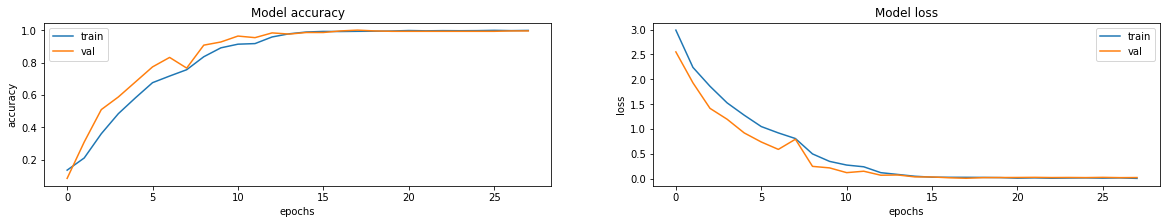

In [28]:
img_save_path = "./img/v3/"
ig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))

img_name = img_save_path + "ANBWv3_acc_loss.png"
if not(os.path.isfile(img_name)):
    plt.savefig(img_name, facecolor="#eeeeee", bbox_inches="tight")

plt.show()